# [과제 2] 회귀분석
### - Ch 1, Ch 2를 토대로 자유롭게 회귀분석과 회귀진단을 진행해주세요.
### - 주석으로 설명 및 근거 자세하게 달아주시면 감사하겠습니다. :)

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 100)

# Data 

데이터 출처 : https://www.kaggle.com/avikasliwal/used-cars-price-prediction 

< y > 
* **Price** : The price of the used car in INR Lakhs.



< X > 
* Name : The brand and model of the car
* Location : The location in which the car is being sold or is available for purchase.
* Year : The year or edition of the model.
* Kilometers_Driven : The total kilometres driven in the car by the previous owner(s) in KM.
* Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
* Transmission : The type of transmission used by the car. (Automatic / Manual)
* Owner_Type : Whether the ownership is Firsthand, Second hand or other.
* Mileage : The standard mileage offered by the car company in kmpl or km/kg
* Engine : The displacement volume of the engine in CC.
* Power : The maximum power of the engine in bhp.
* Seats : The number of seats in the car.
* New_Price : The price of a new car of the same model.

In [3]:
# Load Data 
data = pd.read_csv("assignment2_data.csv")
data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [4]:
# data = pd.read_csv("assignment2_train-data.csv")
# data.head()

# 간단한EDA & FE

In [5]:
# 필요없는 열 제거 
data.drop('Unnamed: 0', axis=1, inplace=True)

## 결측치 확인 
- Engine, Power, Seats, New_Price의 결측치 비율은 상당히 높음 (50% 이상)
- 그 외에도 Mileage에서 결측치 발생

In [6]:
for col in data.columns:
    print(f'\'{col}\'의 결측치의 비율은 {data[col].isna().mean()*100}% \n')

'Name'의 결측치의 비율은 0.0% 

'Location'의 결측치의 비율은 0.0% 

'Year'의 결측치의 비율은 0.0% 

'Kilometers_Driven'의 결측치의 비율은 0.0% 

'Fuel_Type'의 결측치의 비율은 0.0% 

'Transmission'의 결측치의 비율은 0.0% 

'Owner_Type'의 결측치의 비율은 0.0% 

'Mileage'의 결측치의 비율은 0.033228110981890685% 

'Engine'의 결측치의 비율은 0.5981059976740323% 

'Power'의 결측치의 비율은 0.5981059976740323% 

'Seats'의 결측치의 비율은 0.6977903306197043% 

'New_Price'의 결측치의 비율은 86.31001827546105% 

'Price'의 결측치의 비율은 0.0% 



## Target 분석 
- 정규분포를 따른다고 보기 어려움

<AxesSubplot:ylabel='Density'>

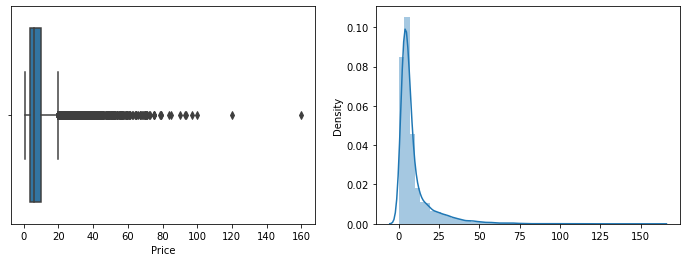

In [7]:
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.boxplot(data["Price"], ax=ax1)
sns.distplot(data[["Price"]],ax=ax2)

## `Name`
- Name에서 parsing 할 수 있는 자동차 브랜드를 categorical 변수로 활용
- 실제로 brand별 Price는 매우 상이하므로 유의미한 변수임 

In [8]:
#데이터에서 높은 비중을 차지하는 차량 이름이 있음
data.Name.value_counts(normalize=True) 

Mahindra XUV500 W8 2WD                                0.008141
Maruti Swift VDI                                      0.007476
Maruti Swift Dzire VDI                                0.005649
Honda City 1.5 S MT                                   0.005649
Maruti Swift VDI BSIV                                 0.005150
                                                        ...   
Skoda Rapid 1.5 TDI AT Elegance Plus Black Package    0.000166
Volkswagen Vento Petrol Comfortline                   0.000166
Volvo S80 D5                                          0.000166
Chevrolet Optra 1.6 LS                                0.000166
Hyundai i20 Active SX Petrol                          0.000166
Name: Name, Length: 1876, dtype: float64

In [9]:
# 차량의 이름은 1876개의 종류가 있음 
data.Name.nunique() 

1876

In [10]:
# Name에서 차량의 브랜드명만 추출
data['brand'] = data.Name.apply(lambda x: x.split(' ')[0]) 

In [11]:
# 일반적으로 많이 볼 수 있는 차량 브랜드부터 고급 차량 브랜드까지 다양한 종류가 있음
data['brand'].value_counts() 

Maruti           1211
Hyundai          1107
Honda            608 
Toyota           411 
Mercedes-Benz    318 
Volkswagen       315 
Ford             300 
Mahindra         272 
BMW              267 
Audi             236 
Tata             186 
Skoda            173 
Renault          145 
Chevrolet        121 
Nissan           91  
Land             60  
Jaguar           40  
Fiat             28  
Mitsubishi       27  
Mini             26  
Volvo            21  
Porsche          18  
Jeep             15  
Datsun           13  
Force            3   
ISUZU            2   
Bentley          1   
Smart            1   
Lamborghini      1   
Isuzu            1   
Ambassador       1   
Name: brand, dtype: int64

In [12]:
# 브랜드 별로 unique한 자동차 종류의 개수
data.groupby('brand').agg(브랜드별차종개수=('Name','nunique'))

,브랜드별차종개수
brand,
Ambassador,1
Audi,69
BMW,87
Bentley,1
Chevrolet,43
Datsun,9
Fiat,20
Force,2
Ford,114


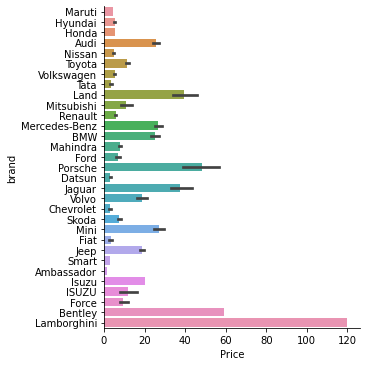

In [13]:
# catplot 
sns.catplot(x='Price', y='brand', data=data, kind='bar')
plt.show()

## `Location`
- Mumbai가 제일 많고 Ahmedbad가 제일 적음
- 눈이 많이 오는 강원도의 중고차는 사지 않는 것이 좋다는 말이 있듯이, 중고차의 위치는 매우 중요한 특성이 될 수도 
- 실제 데이터 상에서 Location에 따른 Price의 변화는 크지 않음 

In [14]:
# value counts
data.Location.value_counts(normalize=True) 

Mumbai        0.131251
Hyderabad     0.123276
Kochi         0.108158
Coimbatore    0.105665
Pune          0.103339
Delhi         0.092042
Kolkata       0.088885
Chennai       0.082073
Jaipur        0.068616
Bangalore     0.059478
Ahmedabad     0.037215
Name: Location, dtype: float64

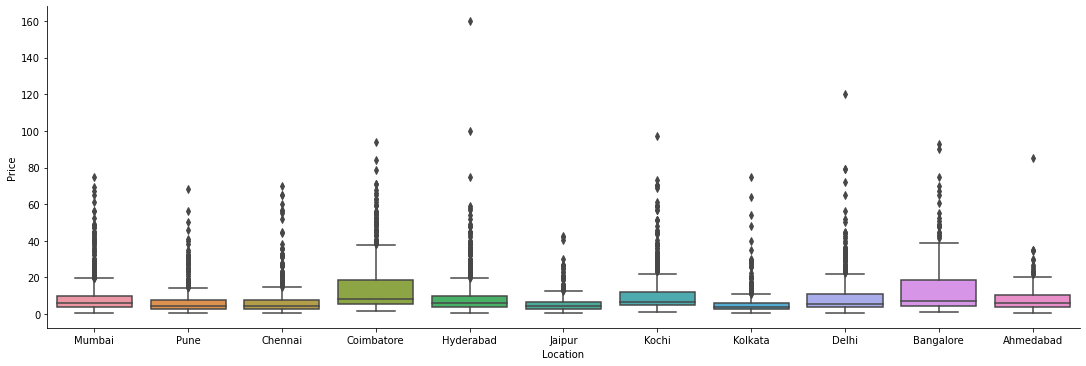

In [15]:
# catplot 
sns.catplot(x='Location', y='Price', data=data, kind='box',aspect=3)
plt.show()

## Year
- 연도가 오래될수록 중고차 가격이 떨어질 가능성이 클 것임
- **적당한 bin을 나누어서 범주화하는 방법을 활용** ('very old', 'old', 'normal', 'new', 'very new')
- ==> ordinal encoding


In [16]:
# value counts
data.Year.value_counts()

2014    797
2015    744
2016    741
2013    649
2017    587
2012    580
2011    466
2010    342
2018    298
2009    198
2008    174
2007    125
2019    102
2006    78 
2005    57 
2004    31 
2003    17 
2002    15 
2001    8  
1998    4  
2000    4  
1999    2  
Name: Year, dtype: int64

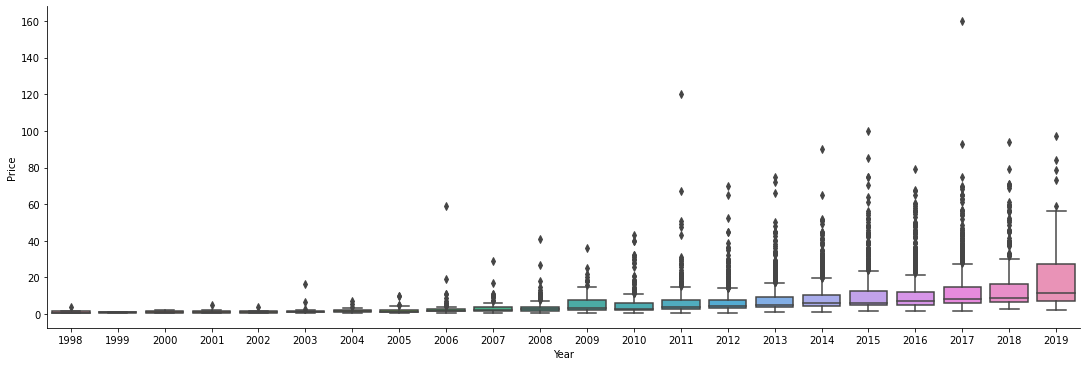

In [17]:
# catplot 
# 1998 ~ 2019 전체
sns.catplot(x='Year', y='Price', data=data, kind='box',aspect=3)
plt.show()

In [18]:
# Year 구간 나누기 
bins = [1997, 2002, 2007, 2012, 2017, 2022]
labels = ['very old', 'old', 'normal', 'new', 'very new']
data['Year_cut'] = pd.cut(data['Year'], bins, right=True, labels=labels)
data['Year_cut'].value_counts()

new         3518
normal      1760
very new    400 
old         308 
very old    33  
Name: Year_cut, dtype: int64

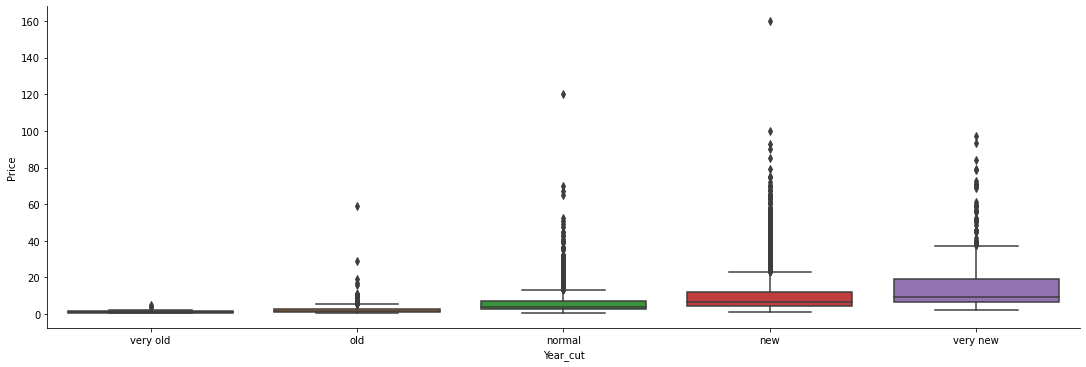

In [19]:
# catplot 
# Year 구간 별로 
sns.catplot(x='Year_cut', y='Price', data=data, kind='box',aspect=3)
plt.show()

## `Fuel_Type`
- Diesel이나 Petrol의 비중이 높음 
- Diesel이나 Electric의 가격이 높음 

In [20]:
data.Fuel_Type.value_counts()

Diesel      3205
Petrol      2746
CNG         56  
LPG         10  
Electric    2   
Name: Fuel_Type, dtype: int64

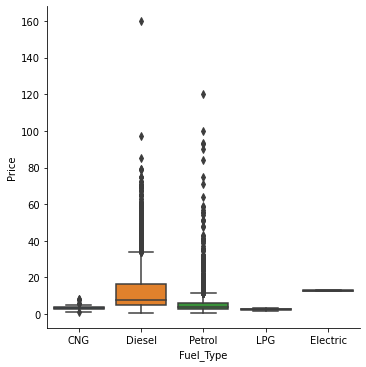

In [21]:
# catplot  
sns.catplot(x='Fuel_Type', y='Price', data=data, kind='box')
plt.show()

## `Transmission`
- Automatic의 비율이 높고 더 비쌈

In [22]:
data.Transmission.value_counts(normalize=True)

Manual       0.714238
Automatic    0.285762
Name: Transmission, dtype: float64

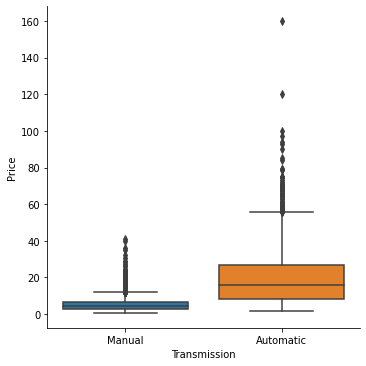

In [23]:
# catplot  
sns.catplot(x='Transmission', y='Price', data=data, kind='box')
plt.show()

## `Owner_Type`
- 같은 중고라도 여러번 재판매되는 제품은 가격이 하락할 가능성이 큼 
- 실제로 First, Second, Third, Fourth&Above순으로 가격이 높게 형성
- => ordinal category로 판단 가능

In [24]:
data.Owner_Type.value_counts()

First             4929
Second            968 
Third             113 
Fourth & Above    9   
Name: Owner_Type, dtype: int64

In [25]:
data.groupby('Owner_Type').Price.mean().sort_values()

Owner_Type
Fourth & Above    3.280000
Third             5.007257
Second            7.599886
First             9.962445
Name: Price, dtype: float64

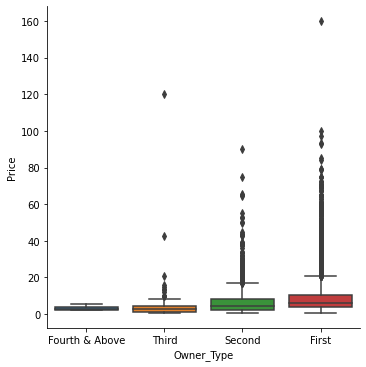

In [26]:
# catplot  
# 가격이 낮은순으로 정렬
sns.catplot(x='Owner_Type', y='Price', data=data, kind='box', order=data.groupby('Owner_Type').Price.mean().sort_values().index)
plt.show()

## `Kilometers_Driven`
- skewed한 분포를 띄고 있으며 로그변환시에 정규성을 띄는 feature로 변환 가능

In [27]:
# describe
data.Kilometers_Driven.describe()

count    6.019000e+03
mean     5.873838e+04
std      9.126884e+04
min      1.710000e+02
25%      3.400000e+04
50%      5.300000e+04
75%      7.300000e+04
max      6.500000e+06
Name: Kilometers_Driven, dtype: float64

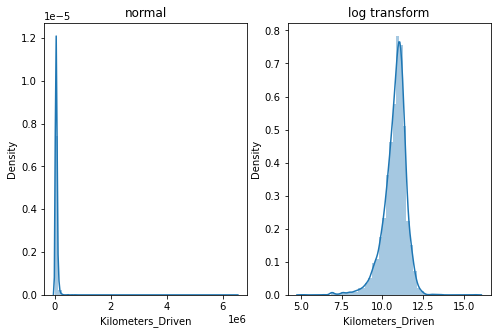

In [28]:
# distplot
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(8,5))
sns.distplot(data['Kilometers_Driven'], ax=ax1)
# 설명변수 로그변환
sns.distplot(np.log(data['Kilometers_Driven']), ax=ax2)

ax1.set_title('normal')
ax2.set_title('log transform')
plt.show()

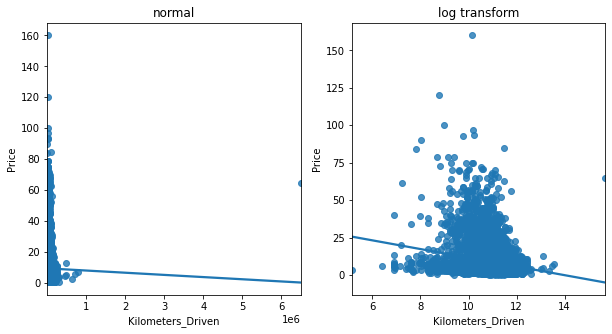

In [29]:
# x, y scatter plot (설명변수와 반응변수 간 선형성 확인)
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,5))
sns.regplot(x='Kilometers_Driven', y='Price', data=data, ci=None, ax=ax1)
# 설명변수 로그변환
sns.regplot(x=np.log(data['Kilometers_Driven']), y='Price', data=data, ci=None, ax=ax2)

ax1.set_title('normal')
ax2.set_title('log transform')

plt.show()

## `Mileage`
- Mileage 측정단위가 km/kg 혹은 kmpl 두가지로 나뉘므로 동일한 수치로 맞춰야할 필요가 있음 (1 km/kg = 1.4* kmpl)
- 결측값이 두개 있음 ==>
- 로그변환을 취하지 않아도 반응변수와의 선형관계를 만족함

In [30]:
# Mileage의 측정단위가 km/kg 혹은 kmpl 두가지
data['unit'] = data.Mileage.astype(str).apply(lambda x: x.split(' ')[-1])
data.unit.value_counts()

kmpl     5951
km/kg    66  
nan      2   
Name: unit, dtype: int64

In [31]:
# Mileage에서 숫자만 빼서 변수 생성
data['Mileage_N'] = data.Mileage.astype(str).apply(lambda x: float(x.split(' ')[0]))

In [32]:
# 1 km/kg = 1.4* kmpl 이므로 kmpl일 때 Mileage를 다르게 계산 
data['Mileage_N'] = np.where(data.Mileage.str.endswith('km/kg'), data['Mileage_N']*1.4, data['Mileage_N'])

In [33]:
# Mileage 수치값만 따로 계산한 Mileage_N
display(data['Mileage_N'].head())
# 단위 포함 Mileage
display(data['Mileage'].head())

0    37.24
1    19.67
2    18.20
3    20.77
4    15.20
Name: Mileage_N, dtype: float64

0    26.6 km/kg
1    19.67 kmpl
2    18.2 kmpl 
3    20.77 kmpl
4    15.2 kmpl 
Name: Mileage, dtype: object

In [34]:
data[data['Mileage_N'].isna()] # Mileage 결측값이 두개 있음 

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,brand,Year_cut,unit,Mileage_N
4446,Mahindra E Verito D4,Chennai,2016,50000,Electric,Automatic,First,NaN,72 CC,41 bhp,5.0,13.58 Lakh,13.00,Mahindra,new,nan,NaN
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000,Electric,Automatic,First,NaN,1798 CC,73 bhp,5.0,NaN,12.75,Toyota,normal,nan,NaN


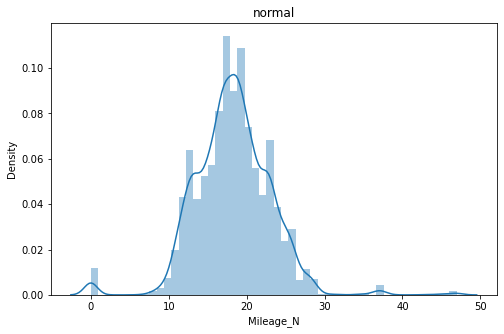

In [35]:
# distplot
fig, ax1 = plt.subplots(1,1, figsize=(8,5))
sns.distplot(data['Mileage_N'], ax=ax1)

ax1.set_title('normal')
plt.show()

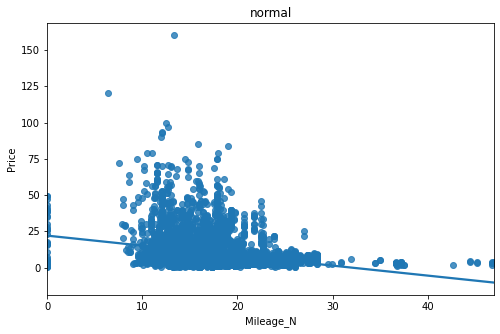

In [36]:
# x, y scatter plot (설명변수와 반응변수 간 선형성 확인)
fig, ax1 = plt.subplots(1,1, figsize=(8,5))
sns.regplot(x='Mileage_N', y='Price', data=data, ci=None, ax=ax1)

ax1.set_title('normal')

plt.show()

## `Engine`
- CC 단위를 빼서 수치형 자료로 변환 
- 로그변환을 취하지 않아도 반응변수와의 선형관계를 만족함

In [37]:
# CC를 빼도 될 듯 ==> numerical feature로 변환
data['Engine'].value_counts()

1197 CC    606
1248 CC    512
1498 CC    304
998 CC     259
2179 CC    240
          ... 
1489 CC    1  
2487 CC    1  
1468 CC    1  
5204 CC    1  
2495 CC    1  
Name: Engine, Length: 146, dtype: int64

In [38]:
# 문자열 CC를 빼고 float으로 변환 
data['Engine'] = data['Engine'].astype(str).apply(lambda x: float(x.split(' ')[0]))

In [39]:
data['Engine'].value_counts()

1197.0    606
1248.0    512
1498.0    304
998.0     259
2179.0    240
         ... 
2925.0    1  
970.0     1  
4951.0    1  
2092.0    1  
2720.0    1  
Name: Engine, Length: 146, dtype: int64

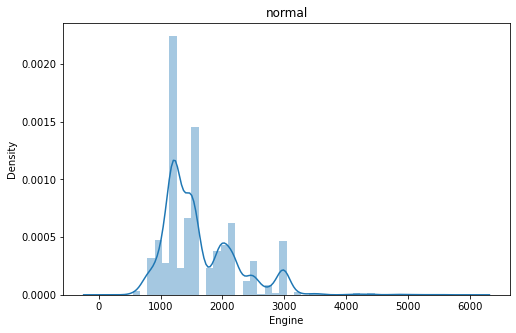

In [40]:
# distplot
fig, ax1 = plt.subplots(1,1, figsize=(8,5))
sns.distplot(data['Engine'], ax=ax1)
ax1.set_title('normal')

plt.show()

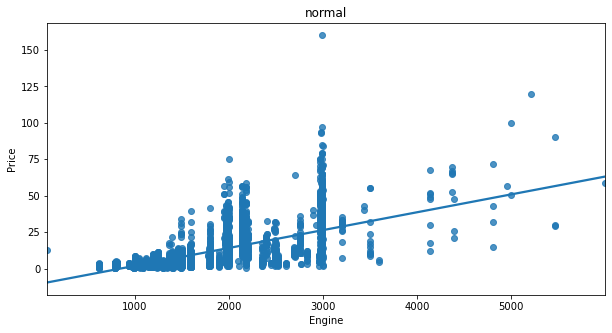

In [41]:
# x, y scatter plot (설명변수와 반응변수 간 선형성 확인)
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.regplot(x='Engine', y='Price', data=data, ci=None, ax=ax1)

ax1.set_title('normal')
ax2.set_title('log transform')

plt.show()

## `Power`
- bhp라는 단위가 포함되어 있음 ==> 전처리하여 수치형으로 변환
- 'null bhp' 같은 형식으로 결측값이 있는 경우가 있음 


In [42]:
# Power 뒤에 bhp같은 단위가 붙어있는 것으로 보임
data.Power.value_counts()

74 bhp       235
98.6 bhp     131
73.9 bhp     125
140 bhp      123
78.9 bhp     111
            ... 
178.4 bhp    1  
76.9 bhp     1  
382 bhp      1  
237.4 bhp    1  
61 bhp       1  
Name: Power, Length: 372, dtype: int64

In [43]:
tmp = data.Power.astype(str).apply(lambda x: x.split(' ')[-1])

# Power 단위의 종류는 전부 bhp
tmp.value_counts()

bhp    5983
nan    36  
Name: Power, dtype: int64

In [44]:
# nan 값이 아닌 문자열 null이 포함되어 있음. 
data.iloc[np.where(data['Power'].str.contains('null'))[0]]['Power'].head()

76     null bhp
79     null bhp
89     null bhp
120    null bhp
143    null bhp
Name: Power, dtype: object

In [45]:
# 문자열 null이 포함된 Power를 np.nan으로 변경
data['Power'] = np.where(data['Power'].str.contains('null'), np.nan, data['Power'])

In [46]:
# 단위를 빼고 Power를 수치형으로 변환 
data['Power'] = data['Power'].astype(str).apply(lambda x: float(x.split(' ')[0]))
data['Power'].head()

0    58.16 
1    126.20
2    88.70 
3    88.76 
4    140.80
Name: Power, dtype: float64

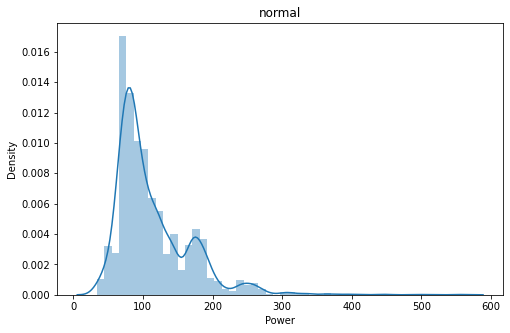

In [47]:
# distplot
fig, ax1 = plt.subplots(1,1, figsize=(8,5))
sns.distplot(data['Power'], ax=ax1)

ax1.set_title('normal')
plt.show()

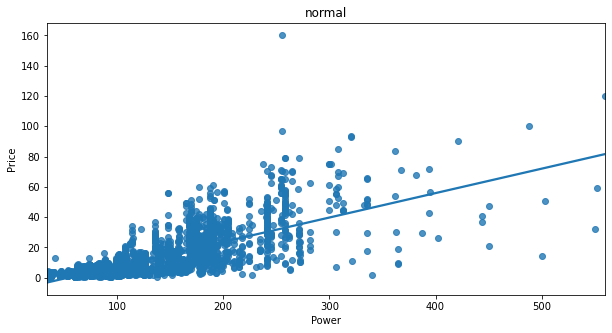

In [48]:
# x, y scatter plot (설명변수와 반응변수 간 선형성 확인)
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.regplot(x='Power', y='Price', data=data, ci=None, ax=ax1)

ax1.set_title('normal')
plt.show()

## `Seats`
- 2인승, 4인승 ... 10인승까지 총 8가지 
- 종류가 별로 없기 때문에 범주화 하는 것을 고려
- 오히려 2인승의 차량이 높은 가격대를 형성 

In [49]:
# value counts 
# seats의 종류는 2인승 ~ 10인승 까지 총 8가지로 구분되어 있음
# 0은 결측값으로 보임
data.Seats.value_counts(dropna=False)

5.0     5014
7.0     674 
8.0     134 
4.0     99  
NaN     42  
6.0     31  
2.0     16  
10.0    5   
9.0     3   
0.0     1   
Name: Seats, dtype: int64

In [50]:
# 0값을 결측값으로 임시 변경 
data['Seats'].replace(0, np.nan, inplace=True)

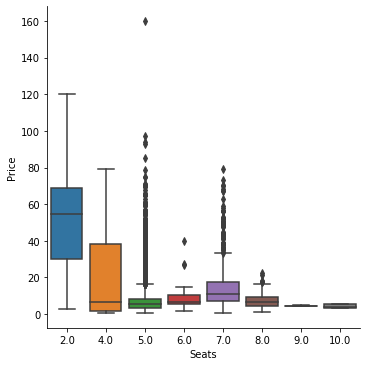

In [51]:
# catplot 
sns.catplot(x='Seats', y='Price', data=data, kind='box')
plt.show()

## `New_Price`
- New_Price를 표현하는 화폐 단위가 Cr과 Lakh로 상이함
- One crore is equal to 100 lakhs. ==> **100*1lakhs = 1crore**
- New_Price의 결측값 비율이 너무 높아 사용 X (86%)

In [52]:
data['New_Price'].value_counts()

4.78 Lakh     6
63.71 Lakh    6
95.13 Lakh    6
4.98 Lakh     5
44.28 Lakh    5
             ..
7.35 Lakh     1
30.19 Lakh    1
7.33 Lakh     1
91.23 Lakh    1
15.01 Lakh    1
Name: New_Price, Length: 540, dtype: int64

In [53]:
# New_Price의 화폐단위를 확인하기 ==> Cr과 Lakh가 존재 
# 여기서 Cr: crore, Lakh: lakhs로 보임
# One crore is equal to 100 lakhs.
tmp = data['New_Price'].astype(str).apply(lambda x: x.split(' ')[-1])
tmp.value_counts()

nan     5195
Lakh    807 
Cr      17  
Name: New_Price, dtype: int64

In [54]:
# 하지만 New_Price의 결측값 비율이 너무 높아 사용 X 
data['New_Price'].isna().mean()

0.8631001827546104

## 결측값 처리
- Engine, Power, Seats, Mileage_N에서 결측값 발생
- 결측값이 발생하는 행을 없애는 것으로 처리 

In [55]:
# 결측값이 있는 열을 지정하고 차례대로 결측값 행을 제거 
na_cols = ['Engine', 'Power', 'Seats', 'Mileage_N']
for col in na_cols:
    data = data[data[col].notna()]
    print(f'{col}결측값 제거 이후 shape: {data.shape}')
    
print(f'\n 최종 data shape: {data.shape}')

Engine결측값 제거 이후 shape: (5983, 17)
Power결측값 제거 이후 shape: (5876, 17)
Seats결측값 제거 이후 shape: (5874, 17)
Mileage_N결측값 제거 이후 shape: (5872, 17)

 최종 data shape: (5872, 17)


## feature 정리 
- use features 를 categorical / numerical로 분류

In [56]:
data.columns

Index(['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'New_Price', 'Price', 'brand', 'Year_cut', 'unit', 'Mileage_N'],
      dtype='object')

In [57]:
# 사용하는 features
use_cols = ['brand', 'Location','Year_cut','Mileage_N', 'Engine', 'Power'
           ,'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type'
           ,'Seats', 'Price']

In [58]:
# categorical features
cat_cols = ['brand', 'Location', 'Fuel_Type', 'Transmission','Owner_Type','Year_cut','Seats']
# numerical features
num_cols = ['Mileage_N', 'Engine', 'Power', 'Kilometers_Driven']
# target
target_col = 'Price'

In [59]:
data = data[use_cols]

In [60]:
data[use_cols].head()

,brand,Location,Year_cut,Mileage_N,Engine,Power,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price
0,Maruti,Mumbai,normal,37.24,998.0,58.16,72000,CNG,Manual,First,5.0,1.75
1,Hyundai,Pune,new,19.67,1582.0,126.20,41000,Diesel,Manual,First,5.0,12.50
2,Honda,Chennai,normal,18.20,1199.0,88.70,46000,Petrol,Manual,First,5.0,4.50
3,Maruti,Chennai,normal,20.77,1248.0,88.76,87000,Diesel,Manual,First,7.0,6.00
4,Audi,Coimbatore,new,15.20,1968.0,140.80,40670,Diesel,Automatic,Second,5.0,17.74


## train/test split

In [61]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, train_size = 0.8, test_size = 0.2, random_state = 100)

In [62]:
train.shape

(4697, 12)

## 범주형 특성 encoding 하기 
1. ordinal: Year_cut, Owner_Type ==> 순서를 나타내는 dictionary로 mapping
    *  `Year_cut`: {'very old': 1, 'old': 2, 'normal': 3, 'new': 4, 'very new': 5}
    * `Owner_Type`: {'Fourth & Above': 1, 'Third': 2, 'Second': 3, 'First': 4}

2. nomial: brand, Location, Fuel_Type, Transmission, Seats
    * label encoding


In [63]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [64]:
# Ordinal Encoding (dictionary 생성)
Year_cut_dict = {'very old': 1, 'old': 2, 'normal': 3, 'new': 4, 'very new': 5}
Owner_Type_dict = {'Fourth & Above': 1, 'Third': 2, 'Second': 3, 'First': 4}

# train
train['Year_cut'] = train['Year_cut'].map(Year_cut_dict)
train['Owner_Type'] = train['Owner_Type'].map(Owner_Type_dict)
# test
test['Year_cut'] = test['Year_cut'].map(Year_cut_dict)
test['Owner_Type'] = test['Owner_Type'].map(Owner_Type_dict)

In [65]:
# Label encoding
label_encoding_cols = ['brand', 'Location', 'Fuel_Type', 'Transmission', 'Seats']

for col in label_encoding_cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

In [66]:
train.head()

,brand,Location,Year_cut,Mileage_N,Engine,Power,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price
4387,2,2,4,16.46,2993.0,258.00,35000,1,0,4,2,52.00
5029,8,2,4,18.16,1196.0,86.80,29875,3,1,4,2,4.85
1390,2,5,4,18.88,1995.0,184.00,30000,1,0,4,2,22.00
1042,10,2,4,24.40,1120.0,71.00,80000,1,1,4,2,3.50
5570,24,2,3,19.72,1461.0,108.45,80000,1,1,4,2,6.75


## 수치형 특성 scaling 
- 선형성에 크게 위배되는 수치형 특성이 없었으므로 log변환 대신 min-max scaler적용

In [67]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [68]:
# min-max scaler 적용
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

# 회귀진단 및 선형회귀 모델 적합

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
import statsmodels.api as sm 

## 변수들 간의 상관관계 파악
- 시각화 결과 engine,power & engine,mileage_n & power,transmission의 corr 높아보임

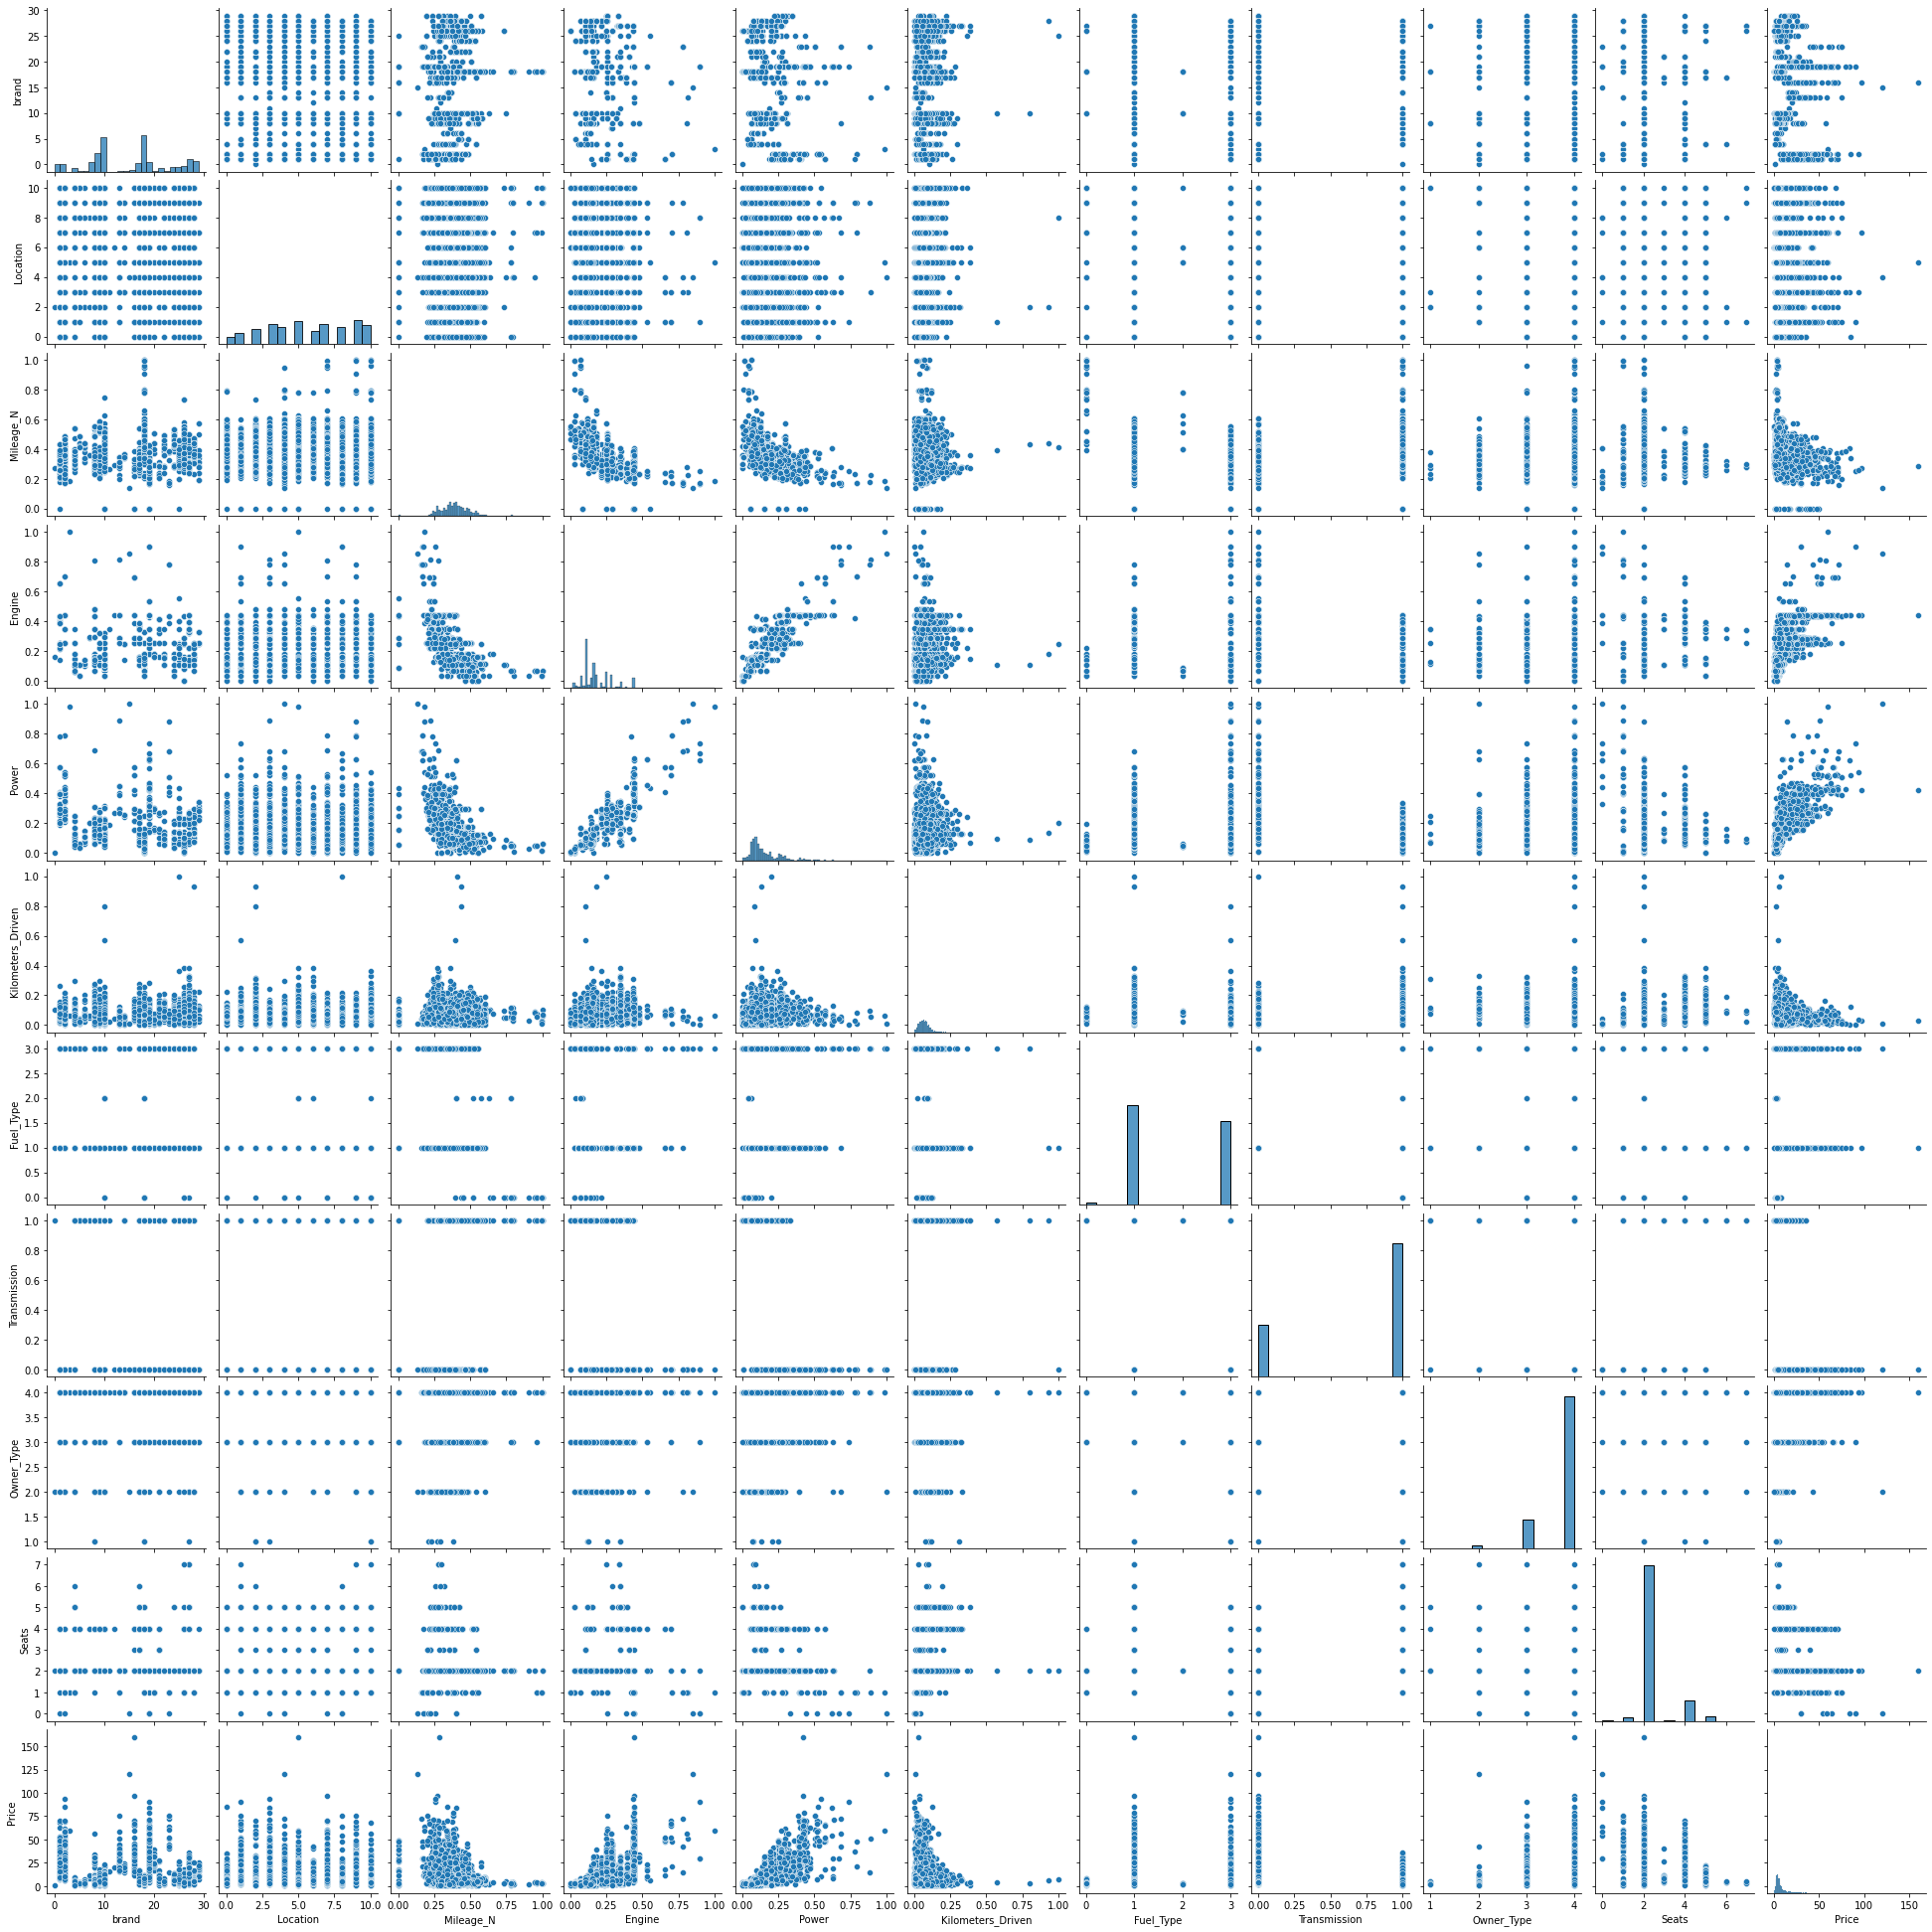

In [70]:
# Correlation using pairplot
sns.pairplot(train)
plt.show()

In [71]:
# correlation df
# correlation 0.6이상이면 색칠
def draw_color_at_nan(x,color):
    if np.abs(x) > 0.6 and np.abs(x) < 1:
        color = f'background-color:{color}'
        return color
    else:
        return ''
    
train.corr().style.applymap(draw_color_at_nan,color='#ff9090')

,brand,Location,Mileage_N,Engine,Power,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price
brand,1.000000,0.039508,-0.011437,-0.011080,-0.195339,0.109171,-0.054264,0.171022,0.032209,0.186378,-0.140600
Location,0.039508,1.000000,0.031191,-0.081509,-0.074928,-0.064258,0.106869,0.052748,0.028867,-0.035007,-0.117984
Mileage_N,-0.011437,0.031191,1.000000,-0.615599,-0.523446,-0.128356,-0.173885,0.355352,0.145432,-0.326375,-0.331327
Engine,-0.011080,-0.081509,-0.615599,1.000000,0.866989,0.166261,-0.402100,-0.504315,-0.064439,0.416139,0.658959
Power,-0.195339,-0.074928,-0.523446,0.866989,1.000000,0.012612,-0.268054,-0.647964,-0.029722,0.118443,0.773787
Kilometers_Driven,0.109171,-0.064258,-0.128356,0.166261,0.012612,1.000000,-0.231498,0.095003,-0.211306,0.210521,-0.153393
Fuel_Type,-0.054264,0.106869,-0.173885,-0.402100,-0.268054,-0.231498,1.000000,0.123349,-0.039473,-0.298986,-0.300790
Transmission,0.171022,0.052748,0.355352,-0.504315,-0.647964,0.095003,0.123349,1.000000,0.001257,0.068832,-0.581265
Owner_Type,0.032209,0.028867,0.145432,-0.064439,-0.029722,-0.211306,-0.039473,0.001257,1.000000,-0.008822,0.085316
Seats,0.186378,-0.035007,-0.326375,0.416139,0.118443,0.210521,-0.298986,0.068832,-0.008822,1.000000,0.071715


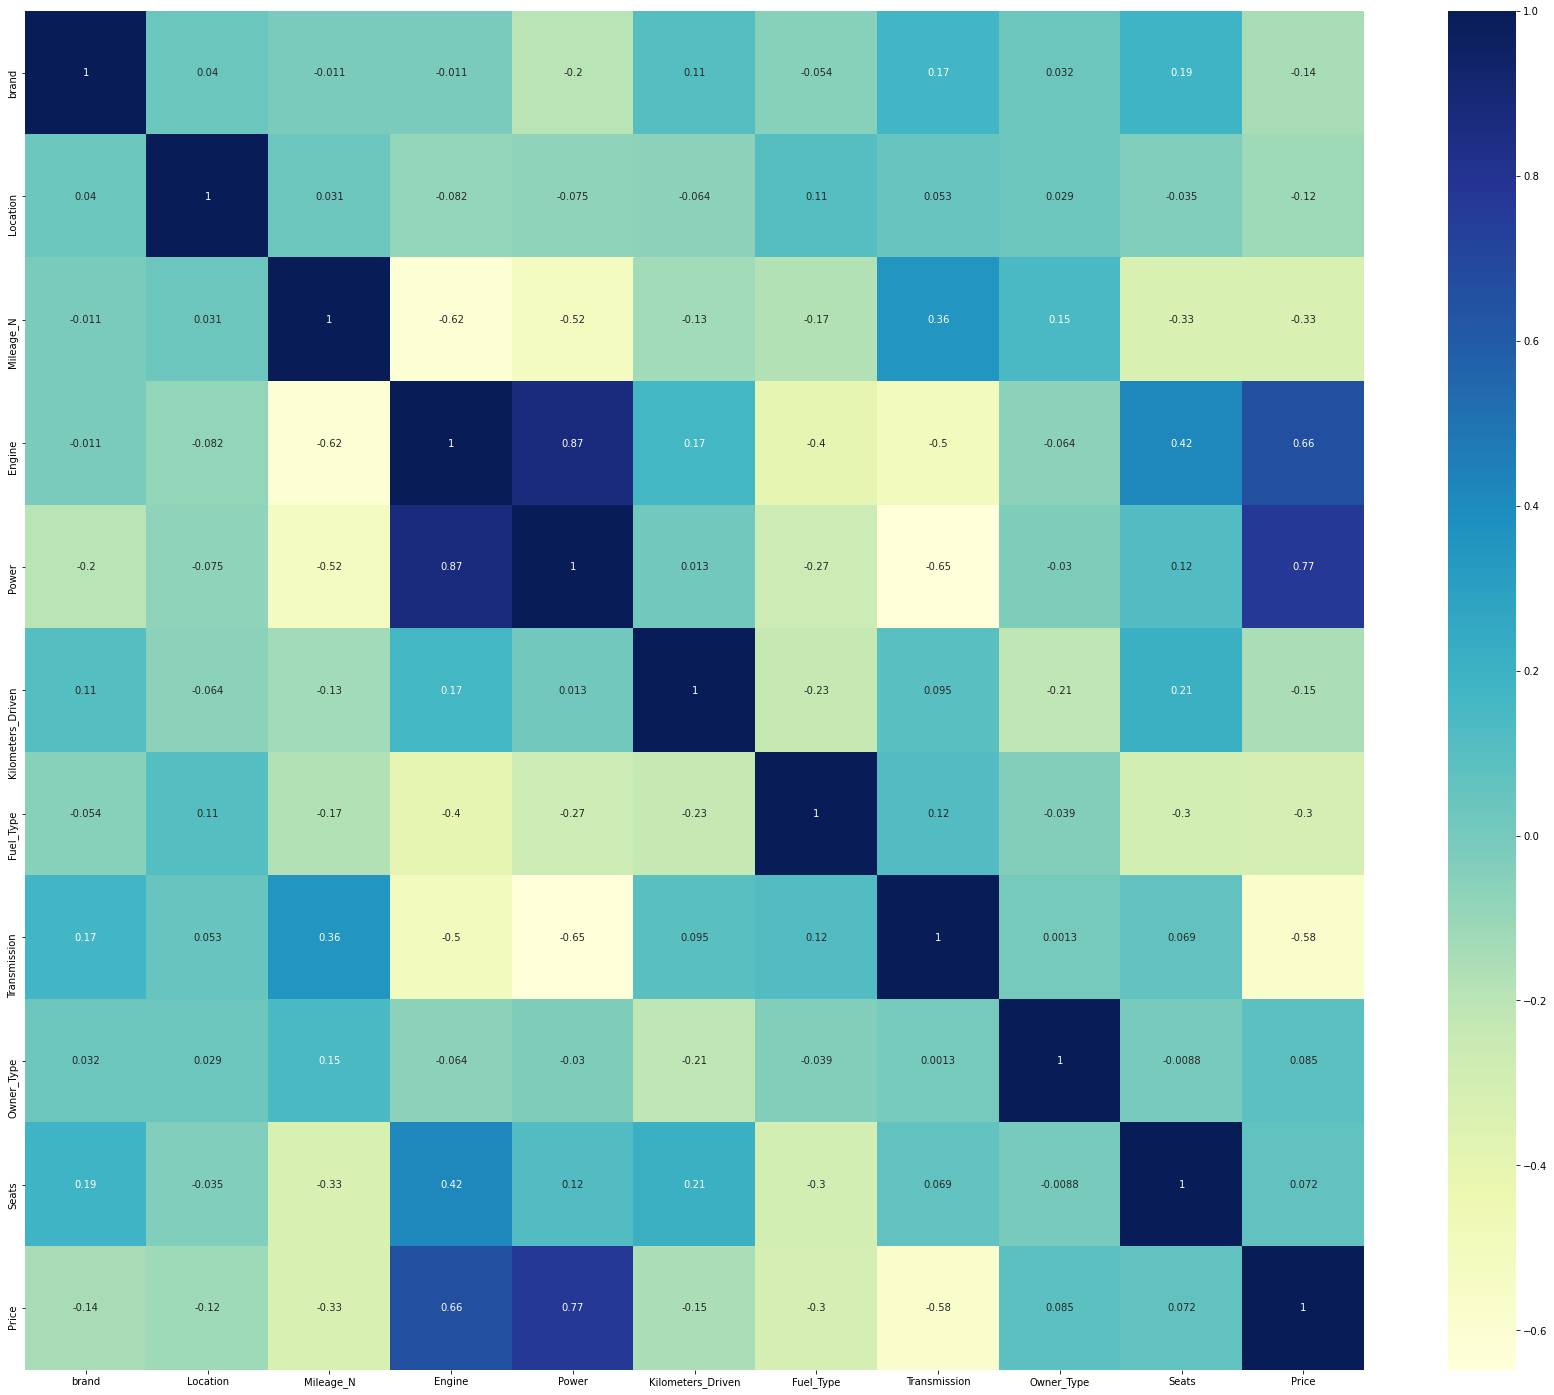

In [72]:
# Correlation using heatmap
plt.figure(figsize = (30, 25))
sns.heatmap(train.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [73]:
# VIF check 
from statsmodels.stats.outliers_influence import variance_inflation_factor

def checkVIF(df):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    vif.sort_values(["VIF Factor"], ascending=[False], inplace=True)
    return vif

In [74]:
vif = checkVIF(train)
vif

,VIF Factor,features
9,65.120964,Owner_Type
2,44.762883,Year_cut
4,33.561088,Engine
3,29.740988,Mileage_N
5,27.333209,Power
10,16.210505,Seats
8,6.625763,Transmission
7,6.110566,Fuel_Type
11,5.543850,Price
0,5.542709,brand


- VIF 다중공선성 진단 결과 `Owner_Type`, `Year_cut`, `Engine`, `Mileage_N`, `Power`, `Seats`에서 다중공선성 의심 ==> 변수 넣고빼기 하면서 VIF 실험 반복
- 하지만 변수를 한,두개 뺀다고 해서 다중공선성이 확실하게 사라지진 않음 ==> 모델 적합으로 확인 필요

In [75]:
tmp = train.drop(['Power'], axis=1)

In [76]:
vif = checkVIF(tmp)
vif

,VIF Factor,features
8,64.799837,Owner_Type
2,44.762867,Year_cut
3,29.023815,Mileage_N
9,14.463018,Seats
4,12.110818,Engine
7,6.218303,Transmission
6,5.625388,Fuel_Type
0,5.149607,brand
10,4.754158,Price
1,4.655011,Location


## statsmodel 회귀 모델 적합 

In [77]:
# X_train, y_train, X_test, y_test 생성
X_train = train.drop('Price', axis=1)
y_train = train['Price']

X_test = test.drop('Price', axis=1)
y_test = test['Price']

In [78]:
# statsmodel 적합 
def build_model(X,y):
    X = sm.add_constant(X) #Adding the constant
    lm = sm.OLS(y,X).fit() # fitting the model
    print(lm.summary()) # model summary
    return X, lm

### model1  (전체 변수로 적합)
- R-squared 값은 0.689로 높은 편에 속함. 따라서 유의미한 모델이라고 볼 수 있음
- F-statistic값이 상당히 높고 이에 따른 p-value값도 당연히 낮으므로 유의미한 변수가 존재하여 모형 자체가 유의미 하다는 것을 증명 
- Durbin-Watson이 1.949로 2에 가깝고 이는 오차항의 자기상관이 없는 독립성을 만족함을 보인다. 
- 하지만 p-value값이 높은 brand, Engine을 제거해서 모델 적합을 해볼 필요가 있음 (Engine을 빼는 것은 다중공선성에도 좋은 영향을 끼칠 수도)

In [79]:
X_train_model1, lm_model = build_model(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     943.4
Date:                Thu, 03 Feb 2022   Prob (F-statistic):               0.00
Time:                        21:53:03   Log-Likelihood:                -15197.
No. Observations:                4697   AIC:                         3.042e+04
Df Residuals:                    4685   BIC:                         3.050e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.3474      1.36

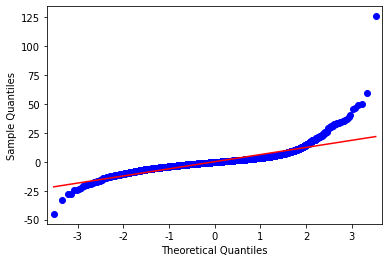

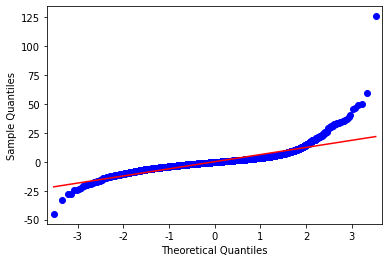

In [80]:
# 시각화를 통해 오차의 정규성을 확인 
model_residuals=lm_model.resid

plt.rcParams["axes.unicode_minus"]=False #폰트 깨짐 방지
sm.ProbPlot(model_residuals).qqplot(line="s")

Text(0, 0.5, 'residuals')

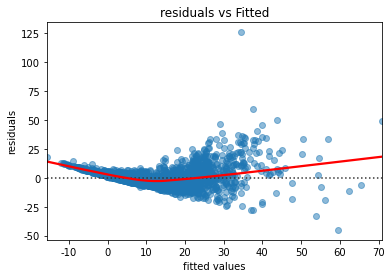

In [81]:
# 시각화를 통해 오차의 등분산성을 확인
model_fitted_y=lm_model.fittedvalues

sns.residplot(model_fitted_y, y_train,data=X_train, lowess=True, scatter_kws={"alpha":0.5},line_kws={"color":"red"})

plt.title("residuals vs Fitted")
plt.xlabel("fitted values")
plt.ylabel("residuals")

### model2 
- t통계량과 관련된 p-value 값이 높았던 `brand`, `Engine`을 제거하고 모델 적합
- 성능의 변화는 거의 없는 것으로 보임 (R-squared, Adj. R-squared 그대로)
- 여전히 Owner_Type, Year_Cut, Mileage_N에서는 다중공선성이 의심됨

In [82]:
X_train2 = X_train.drop(['brand', 'Engine'], axis=1)

In [83]:
X_train_model2, lm_model2 = build_model(X_train2, y_train)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     1152.
Date:                Thu, 03 Feb 2022   Prob (F-statistic):               0.00
Time:                        21:53:12   Log-Likelihood:                -15199.
No. Observations:                4697   AIC:                         3.042e+04
Df Residuals:                    4687   BIC:                         3.048e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.7175      1.31

In [84]:
vif = checkVIF(X_train2)
vif

,VIF Factor,features
7,63.283316,Owner_Type
1,40.735519,Year_cut
2,26.494491,Mileage_N
8,11.613850,Seats
6,6.427208,Transmission
3,5.791185,Power
5,5.162579,Fuel_Type
0,4.593001,Location
4,3.761336,Kilometers_Driven


다중공선성이 의심되는 변수들의 vif 값이 떨어지지는 않는 모습 

## Predict test data 
- model1과 model2로 각각 predict한 후에 evaluation
- model1, model2 모두 test set의 evaluation 성능이 좋지 않음 
- 그나마 `brand`, `Engine`을 제외한 model2가 더 나은 성능 

In [85]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### model1

In [86]:
# shape 맞추기 
X_test_new = X_test[X_train_model1.columns[1:]] # 상수항 제외 
X_test_new = sm.add_constant(X_test_new) # X_test에 상수항 추가 

In [88]:
# predict
y_pred = lm_model.predict(X_test_new)
# r2 score
r2 = r2_score(y_test, y_pred)
# mse
mse = mean_squared_error(y_test, y_pred)

print(f'model1 r2_score: {r2}')
print(f'model1 mse: {mse}')

model1 r2_score: 0.4207753653600316
model1 mse: 84.20123674794489


### model2

In [89]:
# shape 맞추기 
X_test_new = X_test[X_train_model2.columns[1:]] # 상수항 제외 
X_test_new = sm.add_constant(X_test_new) # X_test에 상수항 추가 

In [92]:
# predict
y_pred = lm_model2.predict(X_test_new)
# r2 score
r2 = r2_score(y_test, y_pred)
# mse
mse = mean_squared_error(y_test, y_pred)

print(f'model2 r2_score: {r2}')
print(f'model2 mse: {mse}')

model2 r2_score: 0.42840032420098495
model2 mse: 83.09280501668829


## Ridge, Lasso
- 각각 RidgeCV, LassoCV를 통해 최적의 alpha값을 찾은 후에 모델 적합
- Lasso 모델을 통해 test R-squared 값을 0.5 이상으로 상승시킬 수 있었음

### Ridge model

In [101]:
from sklearn.linear_model import Ridge, RidgeCV

In [104]:
# RidgeCV를 통해 0~10 사이의 숫자 50개 중 최적의 alpha값 선택 
alphas = np.random.uniform(0, 5, 50)
ridge_cv = RidgeCV(alphas = alphas, cv = 10, normalize = True)
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([4.91445461, 0.25597891, 4.28856695, 0.11856132, 4.18049716,
       2.86908146, 3.11378332, 1.31456491, 2.46793864, 2.34938194,
       3.36690365, 4.14738914, 3.84258141, 0.18048862, 2.77522173,
       1.86921716, 0.42061464, 2.64795138, 2.37438593, 3.19726006,
       1.81106145, 4.37144023, 0.66553937, 2.82066951, 1.97224686,
       3.19046861, 4.77227009, 4.53362531, 1.16366706, 3.3438475 ,
       4.32758855, 1.61471196, 2.35722321, 3.97271957, 2.05938825,
       3.75118628, 1.34745179, 2.05861247, 1.09303416, 0.79207167,
       0.01431905, 2.33637949, 0.20187946, 1.2846142 , 4.67847718,
       1.65515265, 1.10052768, 0.57052601, 4.36566562, 0.04724476]),
        cv=10, normalize=True)

In [105]:
# best alpha parameter
alpha = ridge_cv.alpha_
alpha

0.014319046258680634

In [106]:
# Ridge 모델 적합 
ridge = Ridge(alpha = ridge_cv.alpha_)
ridge.fit(X_train, y_train)

Ridge(alpha=0.014319046258680634)

In [107]:
# ridge model의 train r-squared, test r-squared 확인
print(f'train R-squared: {ridge.score(X_train, y_train)}')
print(f'test R-squared: {ridge.score(X_test, y_test)}')

train R-squared: 0.688964007796415
test R-squared: 0.42143734200828775


### Lasso model

In [108]:
from sklearn.linear_model import Lasso, LassoCV

In [109]:
# LassoCV 통해 0~10 사이의 숫자 50개 중 최적의 alpha값 선택 
alphas = np.random.uniform(0, 5, 50)
lasso_cv = LassoCV(alphas = alphas, cv = 10, normalize = True)
lasso_cv.fit(X_train, y_train)

LassoCV(alphas=array([2.53833819, 4.5508295 , 3.28611486, 4.72835651, 1.14616697,
       4.18591353, 4.35698673, 4.46335471, 3.61125218, 3.86594381,
       0.56066226, 2.60207343, 0.01940384, 0.0611183 , 4.1306807 ,
       0.41082619, 2.15034338, 2.7226643 , 4.97944146, 4.55449415,
       2.23354109, 3.66925548, 4.12293226, 3.70468637, 0.80569315,
       3.75070409, 3.08552649, 3.66071318, 4.77571792, 4.08320628,
       1.16572615, 2.63069104, 2.95343594, 3.38725983, 1.64801457,
       2.36061807, 4.00570762, 3.12104397, 2.13405981, 3.25669003,
       0.35178278, 2.92163296, 1.32789319, 4.96591197, 3.00744506,
       2.93628211, 4.60615017, 2.50917113, 2.37647478, 0.00839575]),
        cv=10, normalize=True)

In [110]:
# best alpha parameter
alpha = lasso_cv.alpha_
alpha

0.008395748869975406

In [111]:
# Ridge 모델 적합 
lasso = Lasso(alpha = lasso_cv.alpha_)
lasso.fit(X_train, y_train)

Lasso(alpha=0.008395748869975406)

In [112]:
# lasso model의 train r-squared, test r-squared 확인
print(f'train R-squared: {lasso.score(X_train, y_train)}')
print(f'test R-squared: {lasso.score(X_test, y_test)}')

train R-squared: 0.6884901076036073
test R-squared: 0.515719896491805


Lasso 모델을 통해 test r-squared 값을 많이 상승시킨 것을 확인할 수 있음 

In [141]:
# lasso 모델 적합을 통한 coefficient 확인 
coef = np.abs(lasso.coef_)
# coefficient의 절대값을 내림차순으로 정렬하여 변수의 중요도 확인 
idx = coef.argsort()[::-1]

In [149]:
# coefficient 절대값이 큰 순서대로 print
for i in idx:
    print(f'{X_train.columns[i]}:  {np.round(coef[i],3)}')

Power:  67.823
Kilometers_Driven:  17.961
Mileage_N:  4.184
Year_cut:  3.338
Transmission:  2.706
Engine:  2.162
Fuel_Type:  1.292
Seats:  0.494
Owner_Type:  0.427
Location:  0.203
brand:  0.012


lasso모델이 아예 coefficient를 0으로 수축한 변수는 없었다. 그래서 변수의 중요도를 확인하고자 lasso모델 적합 이후의 회귀 계수들의 절대값을 변수 중요도의 지표로 보고 나열한 결과, lasso모델에서 중요하게 생각하는 변수는 Power, Kilometers_Driven등이 있었고 brand와 Location은 중요 변수로 고려되지 않는 것으로 보였다. 